In [340]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep


## Convolution

In [341]:
single=np.array([[[[5,0,8,7,8,1],
                   [1,9,5,0,7,7],
                   [6,0,2,4,6,6],
                   [9,7,6,6,8,4],
                   [8,3,8,5,1,3],
                   [7,2,7,0,1,0]]]])

single.shape

(1, 1, 6, 6)

In [342]:
identity=np.array([[0,0,0],
                  [0,1,0],
                  [0,0,0]])
identity=identity.reshape(1,1,3,3)
identity.shape

(1, 1, 3, 3)

### Convolving (Applying filters)

In [343]:
region=single[:,:,:3,:3] # NCHW shape

filtered_region=region*identity
total=filtered_region.sum()
total

9

The size of the movement in pixels called `stride`

In [344]:
new_region=single[:,:,:3,1:4]
new_filtered_region=new_region*identity
new_total=new_filtered_region.sum()
new_total

5

The larger the filter, smaller the resulting image  

$(h_i,w_i)*(h_f,w_f)=(h_i-(h_f-1),w_i-(w_f-1))$
$\\(h_i,w_i)*f=(h_i-f+1,w_i-f+1)$


## Convolving in Pytorch

In [345]:
image=torch.as_tensor(single).float()
kernel_identity=torch.as_tensor(identity).float()

Functional convolution

In [346]:
convolved=F.conv2d(image,kernel_identity,stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

Convolutional module: Learn kernel/filter on its own

In [347]:
conv=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,stride=1)
conv(image)

tensor([[[[ 5.3613e-01, -2.8824e-01, -3.6378e+00, -1.5276e+00],
          [-5.7374e-01, -1.2450e+00, -4.9746e-02, -8.6529e-01],
          [ 1.6534e+00, -1.6973e-03, -9.1267e-01, -7.9515e-02],
          [-1.8991e+00, -2.7103e+00, -5.9615e-01, -3.2604e+00]]]],
       grad_fn=<ConvolutionBackward0>)

Learn multiple filters at once


In [348]:
conv_multiple=nn.Conv2d(in_channels=1,out_channels=2,kernel_size=3,stride=1)
conv_multiple.weight

Parameter containing:
tensor([[[[-0.2920, -0.1834, -0.2413],
          [ 0.1653, -0.2235, -0.0278],
          [ 0.0719, -0.1828,  0.0962]]],


        [[[-0.3255, -0.2385, -0.3020],
          [-0.1008, -0.1214,  0.0477],
          [-0.0616,  0.1567,  0.3056]]]], requires_grad=True)

Use convolutional module to use particular weights

In [349]:
with torch.no_grad():
    conv.weight[0]=kernel_identity
    conv.bias[0]=0

conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

$(h_i,w_i)*f=(\frac{h_i-f+1}{s},\frac{w_i-f+1}{s})$

In [350]:
convolution_stride2=F.conv2d(image,kernel_identity,stride=2)
convolution_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

## Padding; to preserve original size of the image after convolution
Expand the input image: Add zero rows and columns around the image

In [351]:
# symmetric padding
constant_padder=nn.ConstantPad2d(padding=1,value=0.0) # padding: num of columns and rows to be stuffed, value: value that filling the new cols and rows
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [352]:
constant_padder(image).shape

torch.Size([1, 1, 8, 8])

In [353]:
# asymetric padding(change pad)
asy_padded=F.pad(image,pad=(1,1,1,1),mode='constant',value=0) # pad=(left,right, top, bottom)
asy_padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

Other padding modes: replicate, reflect, circular

In [354]:
replication_padder=nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [355]:
reflection_padder=nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In [356]:
circular_padding=nn.CircularPad2d(padding=1)
circular_padding(image)

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

$(h_i,w_i)*f=(\frac{h_i+2p-f+1}{s},\frac{w_i+2p-f+1}{s})$

In [357]:
edge=np.array([[[[0,1,0],
                 [1,-4,1],
                 [0,1,0]]]])

kernel_edge=torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

In [358]:
padded_image=F.pad(image,pad=(1,1,1,1),mode='constant',value=0.0)
conv_padded=F.conv2d(input=padded_image,weight=kernel_edge,stride=1)
conv_padded

tensor([[[[-19.,  22., -20., -12., -17.,  11.],
          [ 16., -30.,  -1.,  23.,  -7., -14.],
          [-14.,  24.,   7.,  -2.,   1.,  -7.],
          [-15., -10.,  -1.,  -1., -15.,   1.],
          [-13.,  13., -11.,  -5.,  13.,  -7.],
          [-18.,   9., -18.,  13.,  -3.,   4.]]]])

## Pooling: Shrinking images

In [359]:
pooled=F.max_pool2d(input=conv_padded,kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [360]:
# 4x4 pooling
maxpool4=nn.MaxPool2d(kernel_size=4)
maxpool4(conv_padded)

tensor([[[[24.]]]])

In [361]:
F.max_pool2d(input=conv_padded,kernel_size=3,stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

## Flattening

In [362]:
flattened=nn.Flatten(1,-1)(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [363]:
pooled.view(1,-1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

## Typical Architecture  

**Typical Convolutional block**: Preprocessing images and coverting them into features
1. Convolution
2. Activation function
3. Pooling

In [364]:
# LeNet-5
lenet=nn.Sequential()

# Featurizer
# block 1: 1@28x28-->6@28x28-->6@14x14
lenet.add_module('conv2d1',nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,padding=2))
lenet.add_module('activation1',nn.ReLU())
lenet.add_module('maxpool2d1',nn.MaxPool2d(kernel_size=2))

# block 2: 6@14x14-->16@10x10-->16@5x5
lenet.add_module('conv2d2',nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5))
lenet.add_module('activation2',nn.ReLU())
lenet.add_module('maxpool2d2',nn.MaxPool2d(kernel_size=2))

# block 3: 16@5x5-->120@1x1
lenet.add_module('conv2d3',nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5))
lenet.add_module('activation3',nn.ReLU())
lenet.add_module('flatten',nn.Flatten())

# Classification
# Hidden layer
lenet.add_module('linear1',nn.Linear(in_features=120,out_features=84))
# output layer
lenet.add_module('linear2',nn.Linear(in_features=84,out_features=10))

In [365]:
lenet

Sequential(
  (conv2d1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation1): ReLU()
  (maxpool2d1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (activation2): ReLU()
  (maxpool2d2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (activation3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)

# Multiclass Classification

### Data Generation  

Parallel(Horizontal or vertical) ---> 0  
Diagonal(Tilted to the right) ---> 1  
Diagonal(Tileted to the left) ---> 2  




In [366]:
images,labels=generate_dataset(img_size=10,n_images=1000,binary=False,seed=17)

In [367]:
# fig=plot_images(images,labels,n_plot=30)

### Transformed Dataset

In [368]:
class TransformedTensorDataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x=x
        self.y=y
        self.transform=transform

    def __getitem__(self,index):
        x=self.x[index]
        if self.transform:
            x=self.transform(x)
        return x,self.y[index]
    
    def __len__(self):
        return len(self.x)

### Data preparation

In [369]:
# Build tensors from numpy arrays before split
# Modify pixel values from [0,255] to [0,1]
X_tensor=torch.as_tensor((images/255),dtype=torch.float32)
y_tensor=torch.as_tensor(labels,dtype=torch.long)

# Uses index splitter to generate indices for training and validation sets
train_idx,val_idx=index_splitter(len(X_tensor),[80,20])
# Uses indices to perform split
X_train_tensor,y_train_tensor=X_tensor[train_idx],y_tensor[train_idx]
X_val_tensor,y_val_tensor=X_tensor[val_idx],y_tensor[val_idx]

# we are not doing any data augmentation
train_composer=Compose([Normalize(mean=(0.5),std=(0.5))])
val_composer=Compose([Normalize(mean=(0.5),std=(0.5))])

# Uses custom dataset to apply composed transforms
train_dataset=TransformedTensorDataset(x=X_train_tensor,y=y_train_tensor,transform=train_composer)
val_dataset=TransformedTensorDataset(x=X_val_tensor,y=y_val_tensor,transform=val_composer)

# Build weighted random sampler to handle imbalanced classes
sampler=make_balanced_sampler(y_train_tensor)

# Uses sampler on the training set to get a balanced DataLoader
train_loader=DataLoader(dataset=train_dataset,sampler=sampler,batch_size=16)
val_loader=DataLoader(dataset=val_dataset,batch_size=16)


$\textbf {Softmax} \\$
$z = logit(p) =\text{log odds ratio(p)}=log\frac{p}{1-p}\\$
$e^z = e^{\text{logit}(p)} = \text{odds ratio}(p)=\frac{p}{1-p} \\$
$Softmax(z_i)=\frac{e^z_i}{\sum_{c=0}^{N_c-1} e^{z_c}}$

In [370]:
logits=torch.tensor([1.3863,0.0000,-0.6931])
odd_ratios=torch.exp(logits)
odd_ratios

tensor([4.0000, 1.0000, 0.5000])

In [371]:
softmaxed=odd_ratios/odd_ratios.sum()
softmaxed

tensor([0.7273, 0.1818, 0.0909])

In [372]:
nn.Softmax(dim=-1)(logits)

tensor([0.7273, 0.1818, 0.0909])

In [373]:
F.softmax(logits,dim=-1) # siftmax applies to last dimention

tensor([0.7273, 0.1818, 0.0909])

In [374]:
log_probs=F.log_softmax(logits,dim=-1) # log probs of classes for a single data point
log_probs

tensor([-0.3185, -1.7048, -2.3979])

In [375]:
# Lets assume its label is 2
label=torch.tensor([2])
F.nll_loss(log_probs.view(-1,3),label)

tensor(2.3979)

In [376]:
torch.manual_seed(11)
dummy_logits=torch.randn((5,3))
dummy_labels=torch.tensor([0,0,1,2,1])
dummy_log_probs=F.log_softmax(dummy_logits,dim=-1)
dummy_log_probs

tensor([[-1.5229, -0.3146, -2.9600],
        [-1.7934, -1.0044, -0.7607],
        [-1.2513, -1.0136, -1.0471],
        [-2.6799, -0.2219, -2.0367],
        [-1.0728, -1.9098, -0.6737]])

In [377]:
relevant_log_probs=torch.tensor([-1.5229,-1.7934,-1.0136,-2.0367,-1.9098])
-relevant_log_probs.mean()

tensor(1.6553)

In [378]:
loss_fn=nn.NLLLoss()
loss_fn(dummy_log_probs,dummy_labels)

tensor(1.6553)

In [379]:
loss_fn=nn.NLLLoss(weight=torch.as_tensor([1,1,2],dtype=torch.float32)) # since we need to balance out dataset
loss_fn(dummy_log_probs,dummy_labels)

tensor(1.7188)

In [380]:
# ignore datapoints with label(y=2)
loss_fn=nn.NLLLoss(ignore_index=2)
loss_fn(dummy_log_probs,dummy_labels)

tensor(1.5599)

logits-->`nn.LogSoftmax()`-->log probabilities-->`nn.NLLLoss()`  |  (If last layer is nn.LogSoftmax())    
logits-->nn.CrossEntropyLoss()

In [381]:
torch.manual_seed(11)
dummy_logits=torch.randn((5,3))
dummy_labels=torch.tensor([0,0,1,2,1])

loss_fn=nn.CrossEntropyLoss()
loss_fn(dummy_logits,dummy_labels)

tensor(1.6553)

## Model Config

In [382]:
torch.manual_seed(13)

# featurizer
# Block1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels=3
model_cnn1=nn.Sequential()
model_cnn1.add_module('conv1',nn.Conv2d(in_channels=1,out_channels=n_channels,kernel_size=3))
model_cnn1.add_module('relu1',nn.ReLU())
model_cnn1.add_module('maxp1',nn.MaxPool2d(kernel_size=2))

# Flattening: n_channels _ 4 _ 4
model_cnn1.add_module('flatten',nn.Flatten())

In [383]:
model_cnn1

Sequential(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [384]:
# Classification
model_cnn1.add_module('fc1',nn.Linear(in_features=n_channels*4*4,out_features=10))
model_cnn1.add_module('relu2',nn.ReLU())
model_cnn1.add_module('fc2',nn.Linear(in_features=10,out_features=3))

In [385]:
# Loss and optimizer
lr=0.01
multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
optimizer=optim.SGD(model_cnn1.parameters(),lr=lr)

## Model Training

In [386]:
sbs_cnn1=StepByStep(model=model_cnn1,loss_fn=multi_loss_fn,optimizer=optimizer)
sbs_cnn1.set_loaders(train_loader,val_loader)
sbs_cnn1.train(200)

  0%|          | 0/200 [00:00<?, ?it/s]

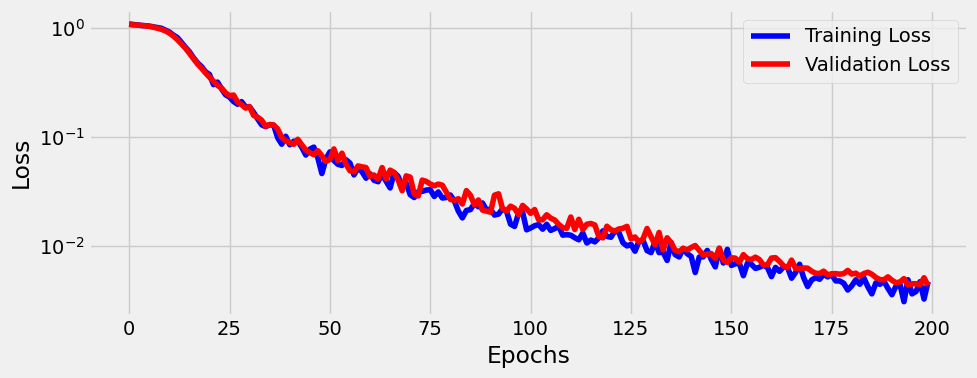

In [387]:
sbs_cnn1.plot_losses()

In [388]:
sbs_cnn1.count_parameters()

553

## Visualizing Filters and more

In [389]:
@staticmethod
def _visualize_tensors(axs,x,y=None,yhat=None,layer_name='',title=None):
    # The number of images is the number of subplots in a row
    n_images=len(axs)
    # Get min and max values for scaling the grayscale
    minv,maxv=np.min(x[:n_images]),np.max(x[:n_images])
    # for each image
    for j, image in enumerate(x[:n_images]):
        ax=axs[j]
        # sets title, labels and remove ticks
        if title is not None:
            ax.set_title(f"{title} #{j}",fontsize=12)
        shp=np.atleast_2d(image).shape
        ax.set_ylabel(f"{layer_name}\n{shp[0]}x{shp[1]}",rotation=0,labelpad=40)
        xlabel1='' if y is None else f"\nLabel: {y[j]}"
        xlabel2='' if yhat is None else f"\nPredicted: {yhat[j]}"
        xlabel=f"{xlabel1}{xlabel2}"

        if len(xlabel):
            ax.set_xlabel(xlabel,fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # plots weights as an image
        ax.imshow(np.atleast_2d(image.squeeze()),
                  cmap='gray',
                  vmin=minv,
                  vmax=maxv)
        return 
    
setattr(StepByStep,'_visualize_tensors',_visualize_tensors)

In [390]:
np.atleast_2d(images[0].squeeze())

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

## Static methods  
Independent of the instance of the class

In [391]:
class Cat(object):
    def __init__(self,name):
        self.name=name

    @staticmethod
    def meow():
        print("meow")

In [392]:
Cat.meow()

meow


### Visualizing filters

In [393]:
weights_filter=model_cnn1.conv1.weight.data.cpu().numpy()
weights_filter.shape # out_channels, in_channels, kernel_size,kernel_size

(3, 1, 3, 3)

In [394]:
from matplotlib import pyplot as plt

def visualize_filters(self,layer_name,**kwargs):
    try:
        # Gets the layer object from the model
        layer=self.model
        for name in layer_name.split('.'):
            layer=getattr(layer,name)
        # we only looking at filters for 2D convolutions
        if isinstance(layer,nn.Conv2d):
            # Takes weight information
            weights=layer.weight.data.cpu().numpy()
            # weights -> (channels_out(filter), channels_in, H, W)
            n_filters,n_channels,_,_=weights.shape

            # Building figure
            size=(2*n_channels+2,2*n_filters)
            fig,axes=plt.subplots(n_filters,n_channels,figsize=size)
            axes=np.atleast_2d(axes)
            axes=axes.reshape(n_filters,n_channels) #rows, columns

            # for each channel out (filter)
            for i in range(n_filters):
                StepByStep._visualize_tensors(axes[i,:],weights[i],layer_name=f'Filter #{i}',title="Channel")

            for ax in axes.flat:
                ax.label_outer()

            fig.tight_layout()
            return fig
        
    except AttributeError:
        return
    
setattr(StepByStep,'visualize_filters',visualize_filters)

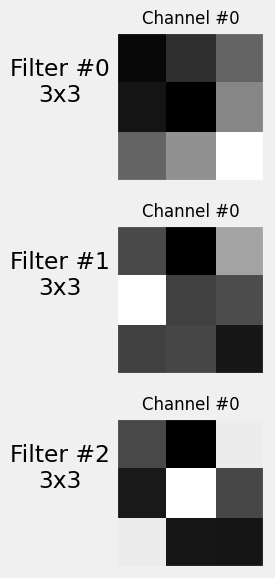

In [395]:
fig=sbs_cnn1.visualize_filters('conv1',cmap='gray')

## Hooks  
force a model to execute a function either after forward pass or backward pass

In [396]:
dummy_model=nn.Linear(1,1)
dummy_list=[]

# forward hook function
def dummy_hook(layer,inputs,outputs):
    dummy_list.append((layer,inputs,outputs))

In [397]:
dummy_handle=dummy_model.register_forward_hook(dummy_hook)
dummy_handle

In [398]:
dummy_x=torch.tensor([0.3])
dummy_model.forward(dummy_x) # dont call forward(x) method

tensor([0.3370], grad_fn=<ViewBackward0>)

In [399]:
dummy_list

[]

In [400]:
dummy_model(dummy_x)

tensor([0.3370], grad_fn=<ViewBackward0>)

In [401]:
dummy_list

[(Linear(in_features=1, out_features=1, bias=True),
  (tensor([0.3000]),),
  tensor([0.3370], grad_fn=<ViewBackward0>))]

In [402]:
dummy_handle.remove() # remove the look

In [403]:
modules=list(sbs_cnn1.model.named_modules())
modules

[('',
  Sequential(
    (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=48, out_features=10, bias=True)
    (relu2): ReLU()
    (fc2): Linear(in_features=10, out_features=3, bias=True)
  )),
 ('conv1', Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))),
 ('relu1', ReLU()),
 ('maxp1',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('flatten', Flatten(start_dim=1, end_dim=-1)),
 ('fc1', Linear(in_features=48, out_features=10, bias=True)),
 ('relu2', ReLU()),
 ('fc2', Linear(in_features=10, out_features=3, bias=True))]

In [404]:
# look up layer names
layer_names={layer:name for name,layer in modules[1:]}
layer_names

{Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1)): 'conv1',
 ReLU(): 'relu1',
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): 'maxp1',
 Flatten(start_dim=1, end_dim=-1): 'flatten',
 Linear(in_features=48, out_features=10, bias=True): 'fc1',
 ReLU(): 'relu2',
 Linear(in_features=10, out_features=3, bias=True): 'fc2'}

In [405]:
# Lets create a real hook function
visualization={}
def hook_fn(layer,inputs,outputs):
    name=layer_names[layer]
    visualization[name]=outputs.detach().cpu().numpy()

In [406]:
layers_to_hook=['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2']

handles={}

for name,layer in modules:
    if name in layers_to_hook:
        handles[name]=layer.register_forward_hook(hook_fn)
        

In [407]:
handles # a handle is a reference to a hook

{'conv1': <torch.utils.hooks.RemovableHandle at 0x7fe0c05ab640>,
 'relu1': <torch.utils.hooks.RemovableHandle at 0x7fe0c05ab0d0>,
 'maxp1': <torch.utils.hooks.RemovableHandle at 0x7fe0c05abf10>,
 'flatten': <torch.utils.hooks.RemovableHandle at 0x7fe0c05aa7a0>,
 'fc1': <torch.utils.hooks.RemovableHandle at 0x7fe0c05abd60>,
 'relu2': <torch.utils.hooks.RemovableHandle at 0x7fe0c05ab490>,
 'fc2': <torch.utils.hooks.RemovableHandle at 0x7fe0c05ab730>}

In [408]:
images_batch, labels_batch=next(iter(val_loader))
logits=sbs_cnn1.predict(images_batch)

In [410]:
visualization.keys()

dict_keys(['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

In [415]:
#Lets remove hooks before checking inside
for handle in handles.values():
    handle.remove()

handles={}

In [434]:
setattr(StepByStep,'visualization',{})
setattr(StepByStep,'handles',{})

def attach_hooks(self,layers_to_hook,hook_fn=None):
    # Clear any previous values
    self.visualization={}
    # Create a dictionary to map layer objects to their names
    modules=list(self.model.named_modules())
    layer_names={layer:name for name,layer in modules[1:]}

    if hook_fn is None:
        # Hook function to be attached to the forward pass
        def hook_fn(layer,inputs,outputs):
            # Get the layer name
            name=layer_names[layer]
            # Detach outputs
            values=outputs.detach().cpu().numpy()
            # since the hook function may be called multiple times (predictions for multiple mini batches) it concatenate results
            if self.visualization[name] is None:
                self.visualization[name]=values
            else:
                self.visualization=np.concatenate([self.visualization[name],values])
    
    for name, layer in modules:
        # if layer is in our list
        if name in layers_to_hook:
            # initialize corresponding key in the dictionary
            self.visualization[name]=None
            # Register the forward hook and keep the handle in another dict
            self.handles[name]=layer.register_forward_hook(hook_fn)

def remove_hooks(self):
    # Loops through all the hooks and remove them
    for handle in self.handles.values():
        handle.remove()
    # Clear the dict as all the hooks have been removed
    self.handles={}


setattr(StepByStep,'attach_hooks',attach_hooks)
setattr(StepByStep,'remove_hooks',remove_hooks)
    

### Hooking it

In [435]:
sbs_cnn1.attach_hooks(layers_to_hook=['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

Making predictions

In [437]:
images_batch,labels_batch=next(iter(val_loader))
logits=sbs_cnn1.predict(images_batch)



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
sbs_cnn1.remove_hooks()